<a href="https://colab.research.google.com/github/TedwardErker/LearnGoogleEarthEngine_TensorFlow_Colab/blob/master/UTC_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Trees via Google Earth Engine and Tensorflow on Google Collab

## Notebook goals


This notebook has several goals.

Further technical skills:
- learn how to use Google Colab
- learn how to use Python's Google Earth Engine API
- learn how to train a convolutional neural network with Tensorflow

Further mission:
- Map urban tree canopy change in two wisconsin counties, Milwaukee and Marathon
- Map urban tree canopy cover in Madison, WI
- Stretch: maps for all cities in the lower 48



### some links to resources
- [Google Earth Engine Documentation](https://developers.google.com/earth-engine)
- [Google Earth Engine API collab setup](https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb#scrollTo=LAZiVi13zTE7)


# Plan

- Set up google earth engine to this collab
- Upload training data for marathon county to google earth engine
- Build simple classifier using just one year of NAIP, assess results
- Upload the lidar derived height raster to google earth engine
- Add the height layer as a feature
- Build simple classifier and asses results
- Upload the Marathon Water layers to google earth engine
- Add water layers as a features
- Build simple classifier and assess results


# Test set up
follow [Google Earth Engine API colab setup](https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb#scrollTo=LAZiVi13zTE7)


In [0]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

### test the API


In [6]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


### Test interactive Map

In [0]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

### Chart Visualization

see also [charting in colaboratory](https://colab.sandbox.google.com/notebooks/charts.ipynb)


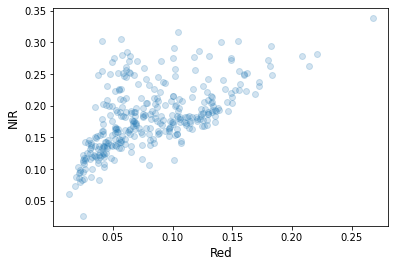

In [8]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

# Load Marathon Training Data

These are in a shapefile that I've created using R.